## Enviroments Settings

In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation
from torch.optim import SGD
# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
%matplotlib notebook

## Solving ODEs

There are two ways to solve an ODE (or ODE system).
1. As a legacy option, ODEs can be solved by `neurodiffeq.ode.solve`. 
2. For users who want fine-grained control over the training process, please consider using a `neurodiffeq.solvers.Solver1d`.

- The first option is easier to use but has been **deprecated** and might be removed in a future version. 
- The second option is **recommended** for most users and supports advanced features like custom callbacks, checkpointing, early stopping, gradient clipping, learning rate scheduling, curriculum learning, etc.

Just for the sake of notation in the following examples, here we see differentiation as an operation, then an ODE can be rewritten as 

$$F(x, t) = 0.$$

### ODE Example 1: Exponential Decay (using the legacy `solve` function)

__To show how simple__ `neurodiffeq` __can be, we'll first introduce the legacy option with the__ `solve` __function form__ `neurodiffeq.ode`__.__

Start by solving 

$$\frac{du}{dt} = -u.$$ 

for $u(t)$ with $u(0) = 1.0$. The analytical solution is 

$$
u = e^{-t}.
$$

For `neurodiffeq.ode.solve` to solve this ODE, the following parameters needs to be specified:

* `ode`: a function representing the ODE to be solved. It should be a function that maps $(u, t)$ to $F(u, t)$. Here we are solving $$F(u, t)=\dfrac{du}{dt} + u=0,$$ then `ode` should be `lambda u, t: diff(u, t) + u`, where `diff(u, t)` is the first order derivative of `u` with respect to `t`.

* `condition`: a `neurodiffeq.conditions.BaseCondition` instance representing the initial condition / boundary condition of the ODE. Here we use `neurodiffeq.conditions.IVP(t_0 = 0, u_0 = 1)` to ensure $u(0) = 1$.

* `t_min` and `t_max`: the domain of $t$ to solve the ODE on.

For `FCNN` to customize our tailor-made neural network, we can adjust hyperparameters by specifying `net`below to satisfy our needs.
* `n_input_units`: Number of units in the input layer, defaults to 1.
* `n_output_units`: Number of units in the input layer, defaults to 1.
* `n_hidden_layers`: Number of units in the input layer, defaults to 1.
* `hidden_units`: Number of units in the input layer, defaults to 32.
* `actv`: The activation layer constructor after each hidden layer, defaults to `torch.nn.Tanh`.
* `n_batches_train`: Number of batches to train in every epoch, where batch-size equals ``train_generator.size``.Defaults to 1.
* `n_batches_valid`: Number of batches to validate in every epoch, where batch-size equals ``valid_generator.size``. Defaults to 4.

In [35]:
exponential = lambda u, t: diff(u, t) + u # specify the ODE, use the `lambda` function directly
init_val_ex = IVP(t_0=0.0, u_0=1.0)       # specify the initial conditon

#specify the neural network architecture. Defaulted to be: the input units and output units = 1, perceptrons in each hidden layer = 32
#actvivation function = torch.nn.Tanh, number of hidden layers = 1, max_epochs = 1000
net_lv = FCNN(n_input_units=1, n_output_units=1, hidden_units=[32],n_hidden_layers=1, actv=torch.nn.Sigmoid)

# specify the optimizer
from itertools import chain

nets = [net_lv]

sgd_ho = SGD(
    chain.from_iterable(n.parameters() for n in nets), # this gives all parameters in `nets`
    lr=0.001,                                          # learning rate
    momentum=0.99,                                     # momentum of SGD
)

# solve the ODE
solution_ex, loss_ex = solve(
    ode=exponential, condition=init_val_ex, net=net_lv,max_epochs = 1000, t_min=0.0, t_max=2.0,optimizer=sgd_ho,
)

C:\Users\Aphelios\Desktop\FYP\codes\I_AM_MASTER\neurodiffeq\networks.py:48: FutureWarning: Ignoring `n_hidden_units` and `n_hidden_layers` in favor of `hidden_units=[32]`
  warn(f"Ignoring `n_hidden_units` and `n_hidden_layers` in favor of `hidden_units={hidden_units}`",
C:\Users\Aphelios\Desktop\FYP\codes\I_AM_MASTER\neurodiffeq\ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(


(Don't be scared, we have two warnings here. As we have explained, the `solve` function still works but is deprecated. Hence we have the warning message, which we'll ignore for now.)

`solve` returns a tuple, where the first entry is the solution (as a function) and the second entry is the history (of loss and other metrics) of training and validation. The solution is a function that maps $t$ to $u$. It accepts `numpy.array` or `troch.Tensor` as its input. The default return type of the solution is `torch.tensor`. If we wanted to return `numpy.array`, we can specify `to_numpy=True`. The history is a dictionary, where the 'train_loss' entry is the training loss and the 'valid_loss' entry is the validation loss. Here we compare the ANN-based solution with the analytical solution:

<IPython.core.display.Javascript object>


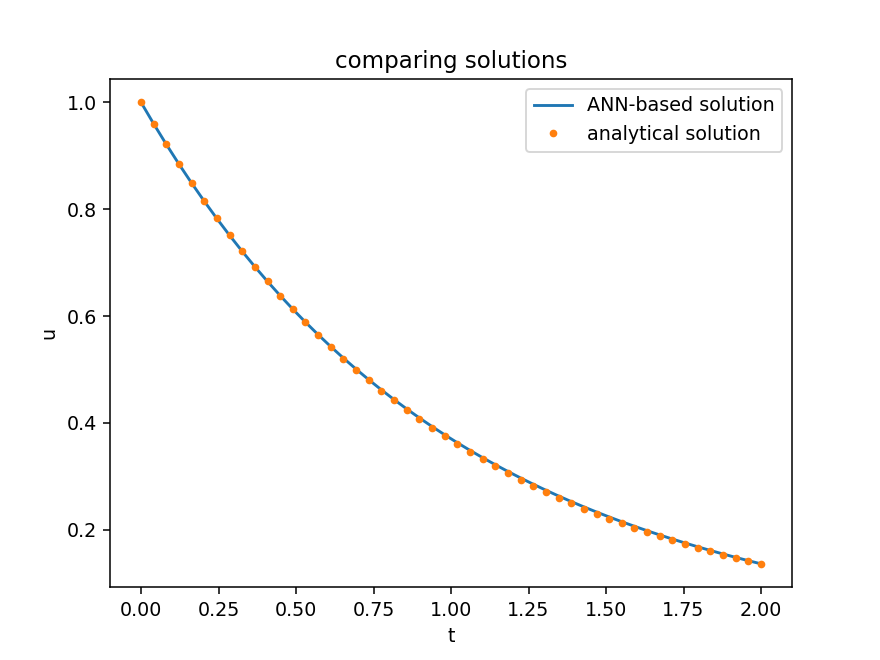

In [36]:
ts = np.linspace(0, 2.0, 50)
u_net = solution_ex(ts, to_numpy=True)
u_ana = np.exp(-ts)

plt.figure()
plt.plot(ts, u_net, label='ANN-based solution')
plt.plot(ts, u_ana, '.', label='analytical solution')
plt.ylabel('u')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


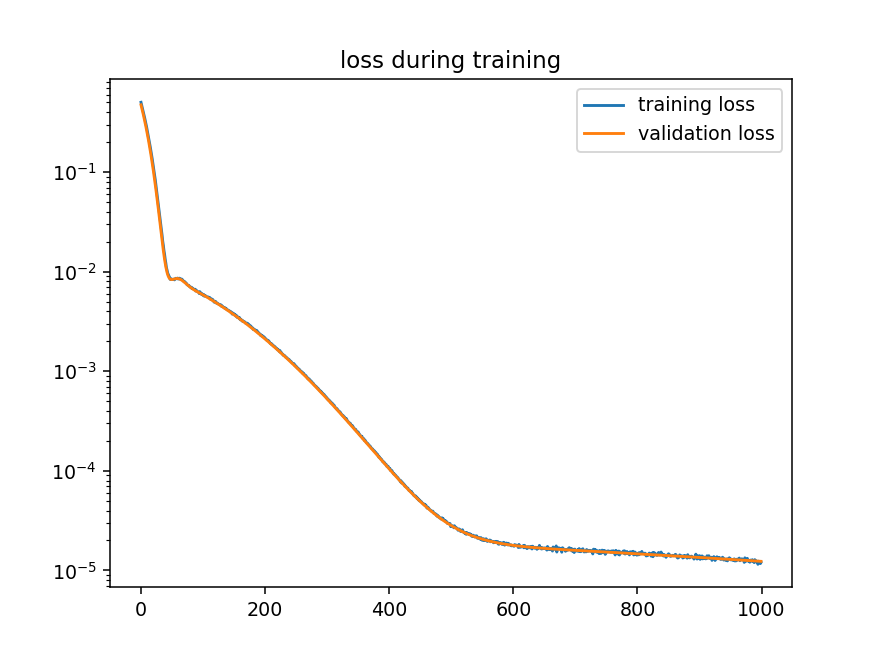

In [8]:
plt.figure()
plt.plot(loss_ex['train_loss'], label='training loss')
plt.plot(loss_ex['valid_loss'], label='validation loss')
plt.yscale('log')
plt.title('loss during training')
plt.legend()
plt.show()

We may want to see the check the solution and the loss function during solving the problem (training the network). To do this, we need to pass a `neurodiffeq.monitors.Monitor1D` object to `solve`. A `Monitor1D` has the following parameters:

* `t_min` and `t_max`: the region of $t$ we want to monitor
* `check_every`: the frequency of visualization. If `check_every=100`, then the monitor will visualize the solution every 100 epochs.

`%matplotlib notebook` should be executed to allow `Monitor1D` to work. Here we solve the above ODE again.

In [9]:
from neurodiffeq.monitors import Monitor1D

<IPython.core.display.Javascript object>


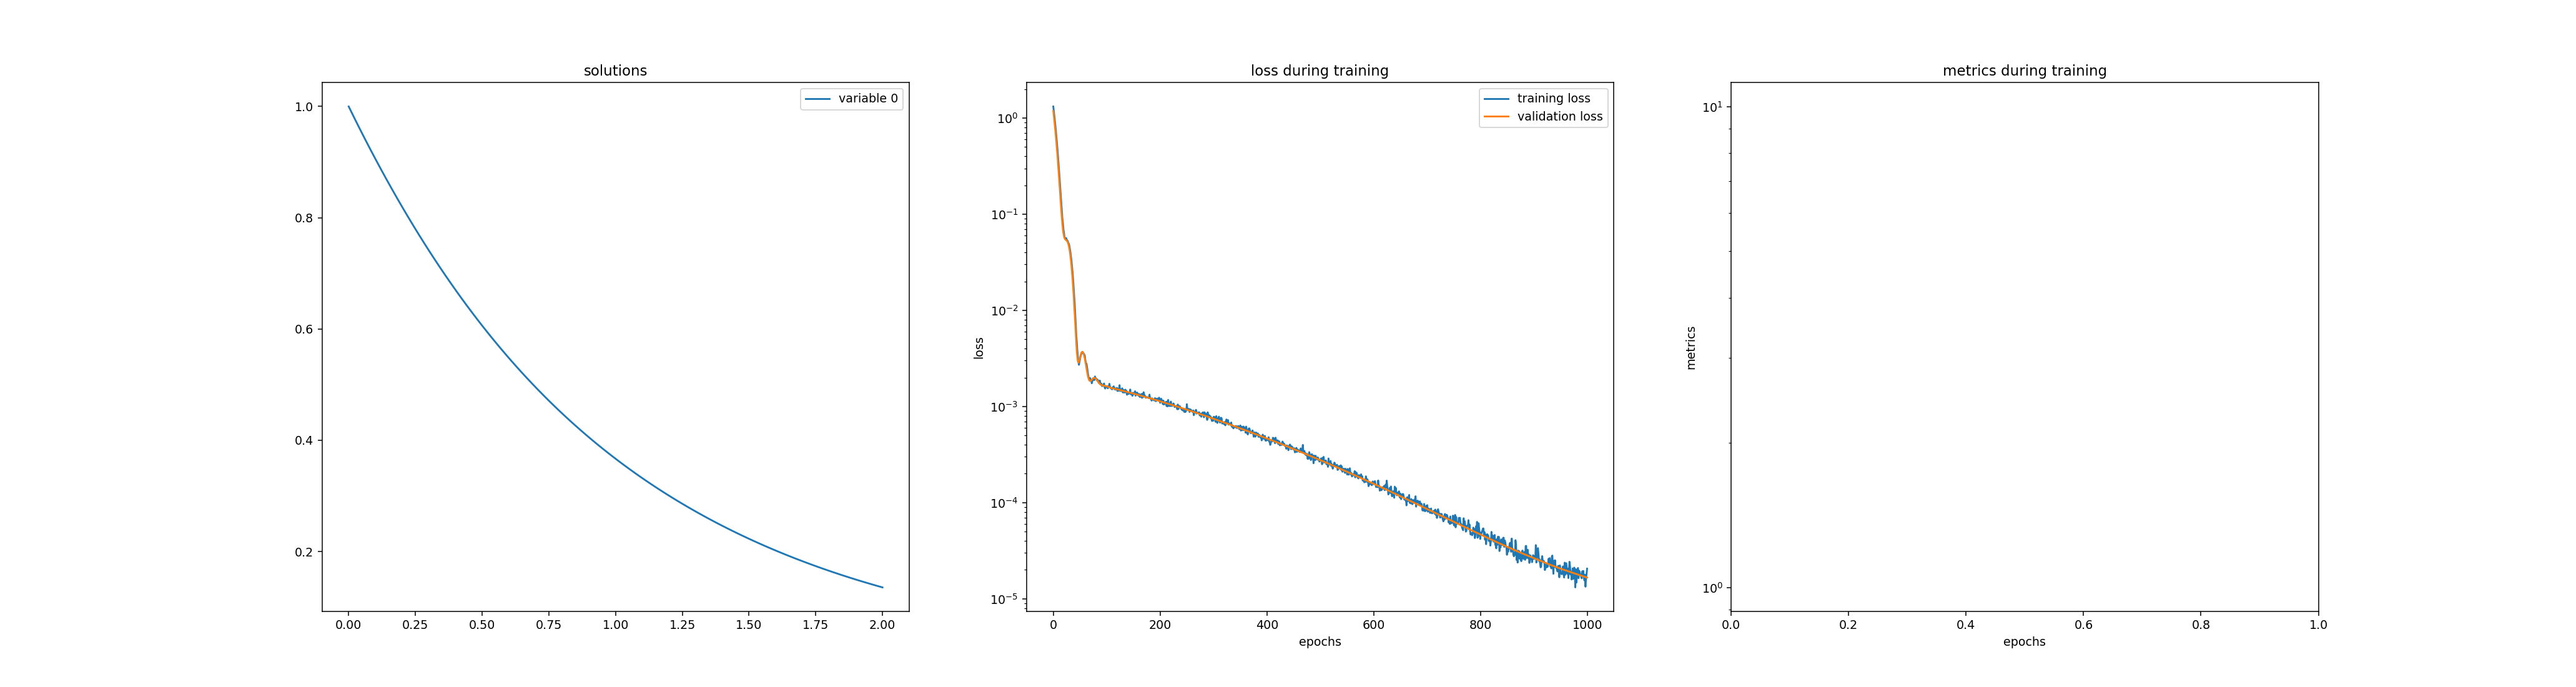

C:\Users\Aphelios\Desktop\FYP\codes\I_AM_MASTER\neurodiffeq\ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(
C:\Users\Aphelios\Desktop\FYP\codes\I_AM_MASTER\neurodiffeq\solvers.py:459: UserWarning: Passing `monitor` is deprecated, use a MonitorCallback and pass a list of callbacks instead
  warnings.warn("Passing `monitor` is deprecated, "


In [10]:
# This must be executed for Jupyter Notebook environments
# If you are using Jupyter Lab, try `%matplotlib widget`
# Don't use `%matplotlib inline`!

%matplotlib notebook 

solution_ex, _ = solve(
    ode=exponential, condition=init_val_ex, t_min=0.0, t_max=2.0, 
    monitor=Monitor1D(t_min=0.0, t_max=2.0, check_every=100)
)

Here we have two warnings. But **don't worry**, the training process is not affected.

- The first one warns that we should use a `neurodiffeq.solvers.Solver1D` instance, which we have discussed before.
- The second warning is slightly different. It says we should use a callback instead of using a `monitor`. Remember we said using a `neurodiffeq.solvers.Solver1D` allows flexible callbacks? This warning is also caused by using the deprecated `solve` function.

### ODE Example 2: Harmonic Oscilator

Here we solve a harmonic oscillator:

$$
F(u, t) = \frac{d^2u}{dt^2} + u = 0
$$

for

$$
u(0) = 0.0, \frac{du}{dt}|_{t=0} = 1.0
$$

The analytical solution is 

$$u = \sin(t)$$

We can include higher order derivatives in our ODE with the `order` keyword of `diff`, which is defaulted to 1.

Initial condition on $\dfrac{du}{dt}$ can be specified with the `u_0_prime` keyword of `IVP`. 

In [11]:
harmonic_oscillator = lambda u, t: diff(u, t, order=2) + u
init_val_ho = IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)

Here we will use another keyword for `solve`:

* `max_epochs`: the number of epochs to run

<IPython.core.display.Javascript object>


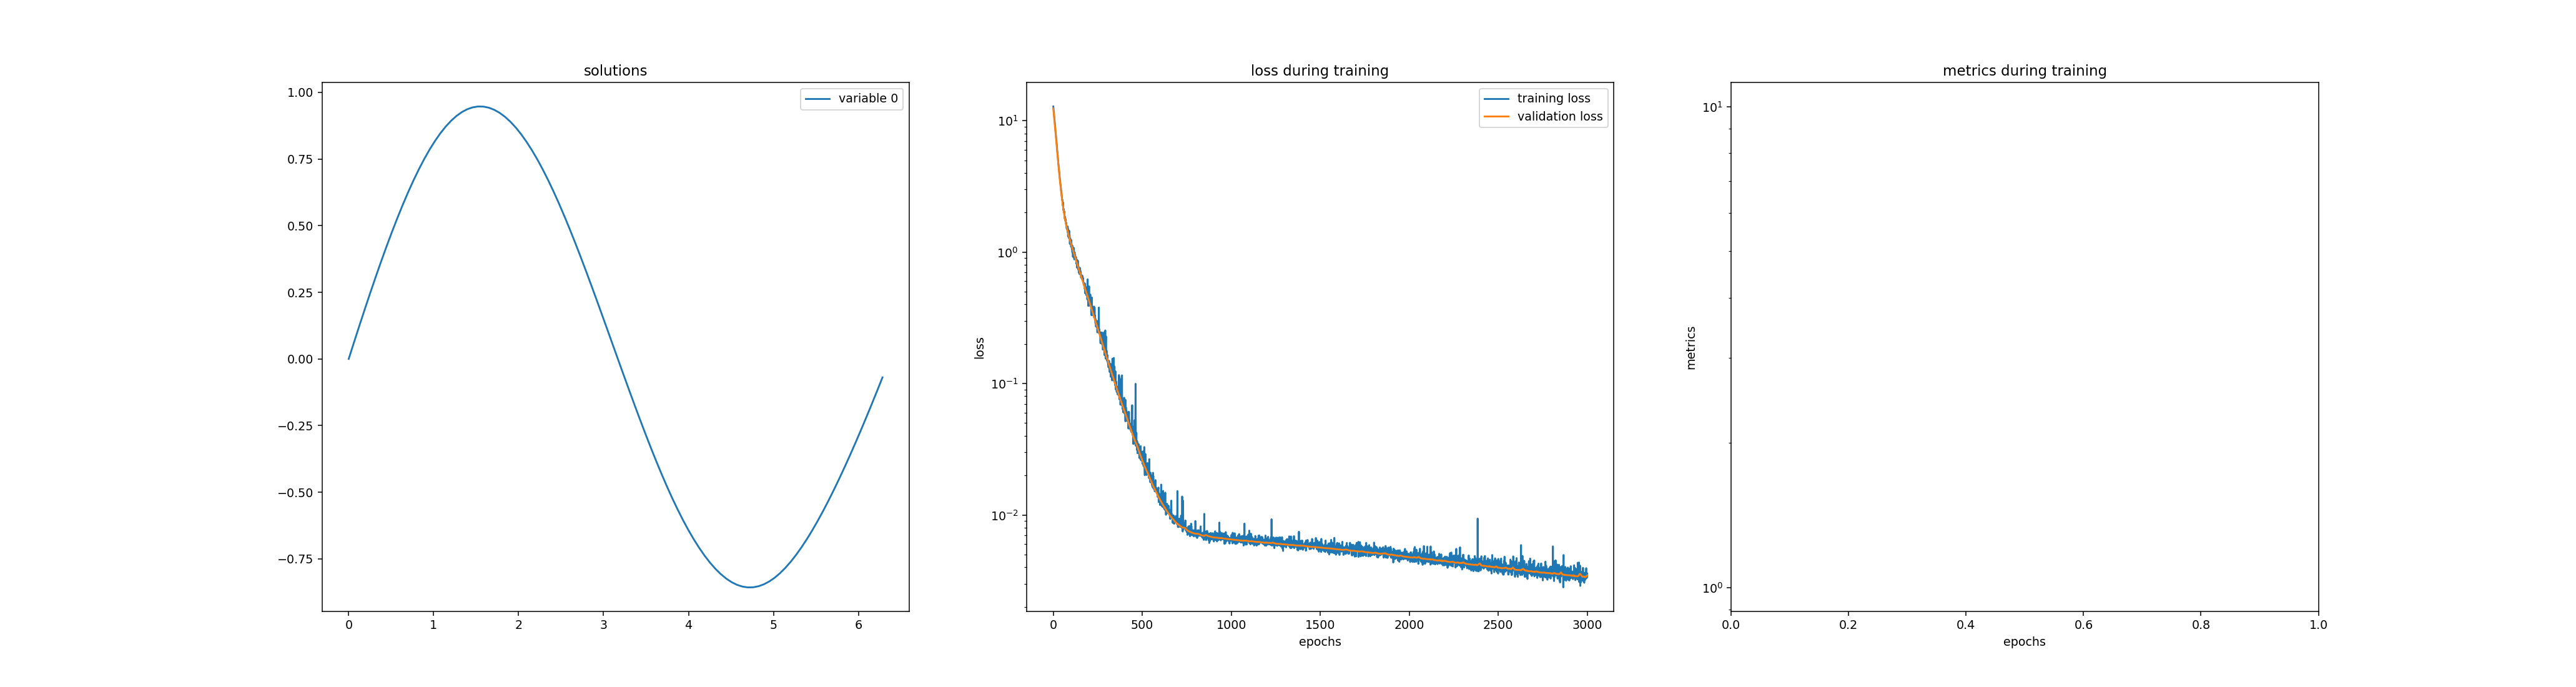

C:\Users\Aphelios\Desktop\FYP\codes\I_AM_MASTER\neurodiffeq\ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(
C:\Users\Aphelios\Desktop\FYP\codes\I_AM_MASTER\neurodiffeq\solvers.py:459: UserWarning: Passing `monitor` is deprecated, use a MonitorCallback and pass a list of callbacks instead
  warnings.warn("Passing `monitor` is deprecated, "


In [12]:
solution_ho, loss_ho = solve(
    ode=harmonic_oscillator, condition=init_val_ho, t_min=0.0, t_max=2*np.pi, 
    max_epochs=3000,
    monitor=Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100)
)

This is the third time we see these warnings. I promise we'll learn to get ride of them by the end of this chapter :)

<IPython.core.display.Javascript object>


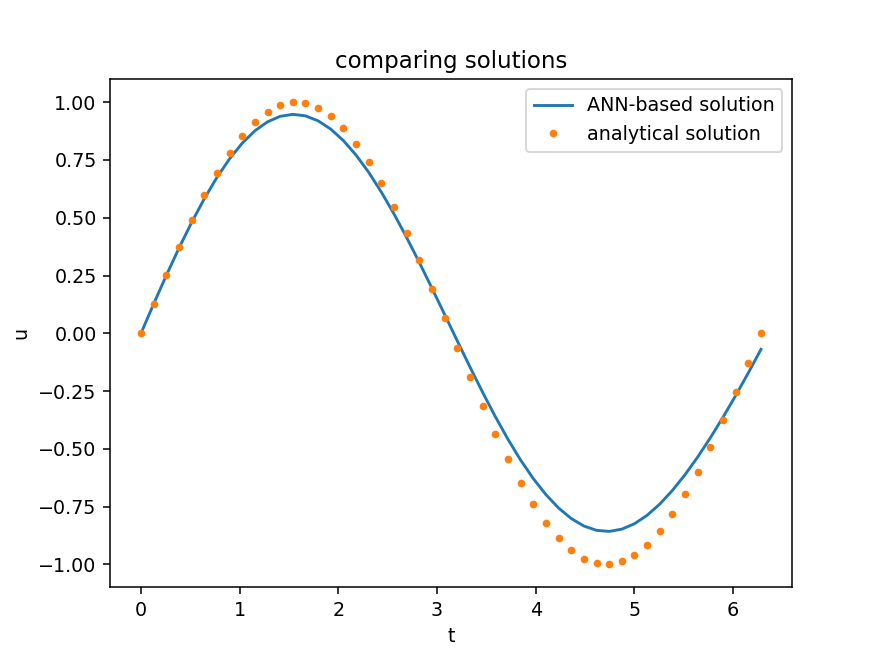

In [13]:
ts = np.linspace(0, 2*np.pi, 50)
u_net = solution_ho(ts, to_numpy=True)
u_ana = np.sin(ts)

plt.figure()
plt.plot(ts, u_net, label='ANN-based solution')
plt.plot(ts, u_ana, '.', label='analytical solution')
plt.ylabel('u')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


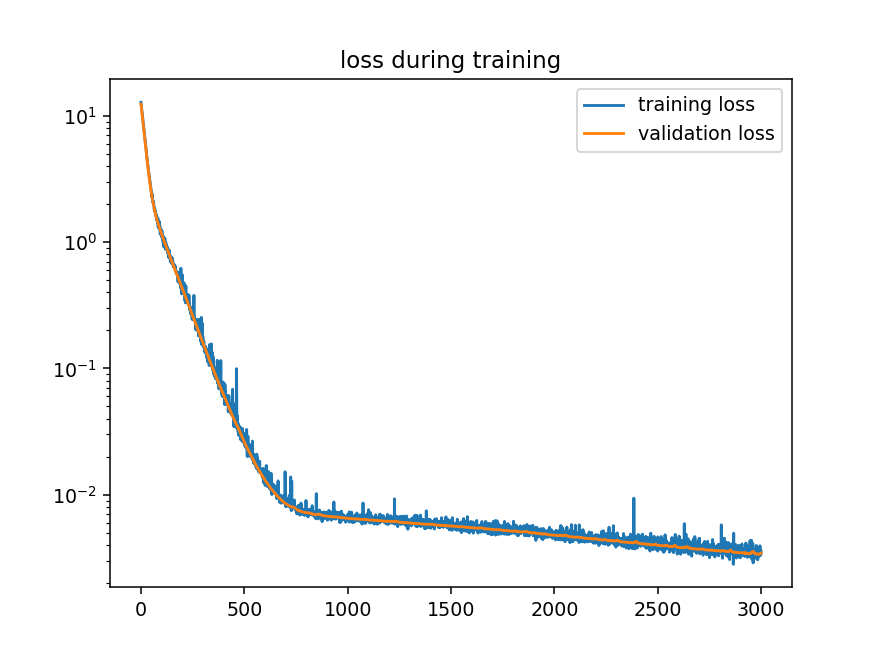

In [14]:
plt.figure()
plt.plot(loss_ho['train_loss'], label='training loss')
plt.plot(loss_ho['valid_loss'], label='validation loss')
plt.yscale('log')
plt.title('loss during training')
plt.legend()
plt.show()

### Specifying the Training Set and Validation Set

Both `Solver*` classes and `solve*` functions train the neural network on a new set of points, randomly sampled every time. These examples are $t$s drawn from the domain of $t$. The way these $t$s are generated can be specified by passing a `neurodiffeq.generators.BaseGenerator` object as the `train_generator` argument (and `valid_generator` argument) to `Solver*` classes or `solve*` functions. An `Generator` can be intialized by the following arguments:

* `size`: the number of $t$s generated for each epoch

* `t_min` and `t_max`: the domain of $t$ from which we want to draw $t$s

* `method`: a string indicating how to generate the $ts$. It should be one of the following: 'uniform', 'equally-spaced', 'equally-spaced-noisy'. If 'uniform', each $t$ will be drawn independently from the uniform distribution $\text{Unif}($`t_min`, `t_max`$)$. If 'equally-spaced', all $t$s generated in the same epoch will form a grid where each $t$ is equally spaced. 'equally-spaced-noisy' is a noisy version of 'equally-spaced' where we add a Gaussian noise $\epsilon \sim \mathcal{N}(0, ($`t_max`-`t_min`)/(4*`size`) $)$

Here we create an `Generator` that generates 64 $t$s drawn from a uniform distribution for every epoch. Then we use it to solve the ODE. In the meantime, foor every epoch, we will use another `Generator` that generates 128 $t$s that are equally spaced in the domain we want to solve.

In [41]:
from neurodiffeq.generators import Generator1D

In [42]:
# Note that the function maps (u, t) to a single-entry list
harmonic_oscillator = lambda u, t: [ diff(u, t, order=2) + u ]
init_val_ho = IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)

<IPython.core.display.Javascript object>


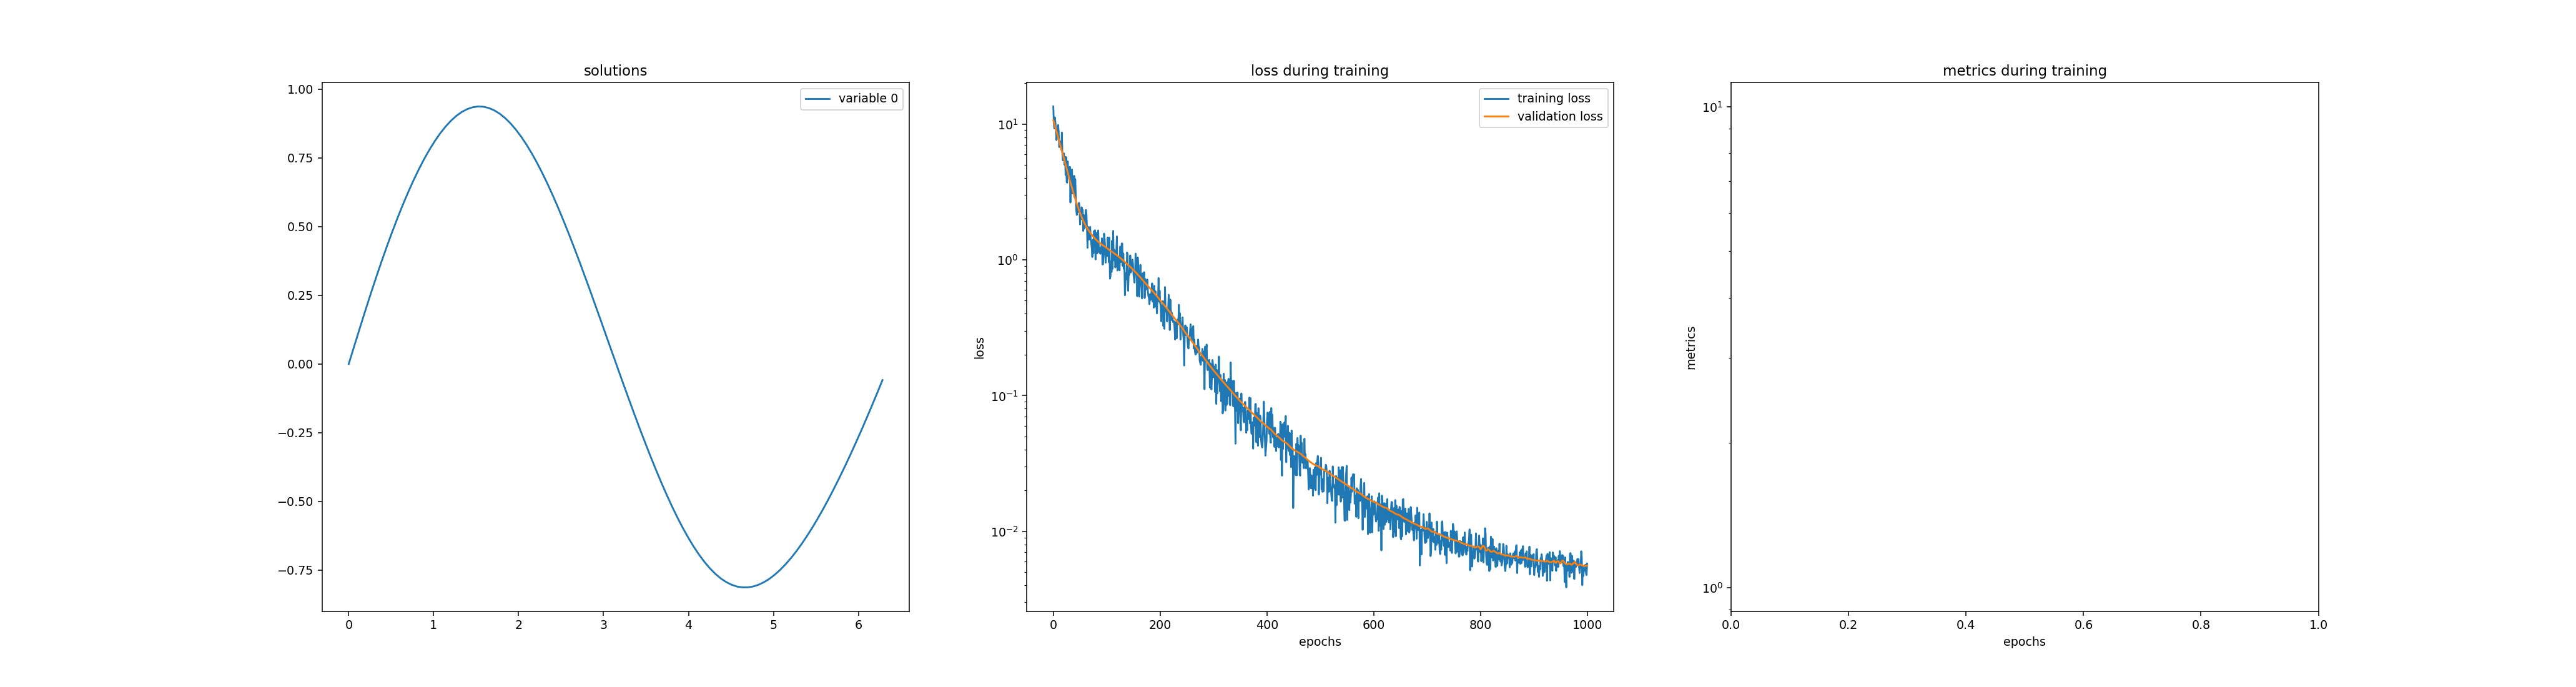

In [43]:
%matplotlib notebook
# specify the training set and validation set
train_gen = Generator1D(size=64,  t_min=0.0, t_max=2*np.pi, method='uniform')
valid_gen = Generator1D(size=128, t_min=0.0, t_max=2*np.pi, method='equally-spaced')

# solve the ODE
solver = Solver1D(
    ode_system=harmonic_oscillator, 
    conditions=[init_val_ho], 
    t_min=0.0, 
    t_max=2*np.pi,
    train_generator=train_gen, 
    valid_generator=valid_gen,
)
solver.fit(
    max_epochs=1000, 
    callbacks=[Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100).to_callback()]
)

solution_ho = solver.get_solution()

## Solving Systems of ODEs

Systems of ODEs can be solved by `neurodiffeq.ode.solve_system`. 

Again, just for the sake of notation in the following examples, here we see differentiation as an operation, and see each element $u_i$of $\vec{u}$ as different dependent vairables, then a ODE system above can be rewritten as

$$
\begin{pmatrix} 
F_0(u_0, u_1, \ldots, u_{m-1}, t) \\
F_1(u_0, u_1, \ldots, u_{m-1}, t) \\
\vdots \\
F_{m-1}(u_0, u_1, \ldots, u_{m-1}, t)
\end{pmatrix}
= 
\begin{pmatrix} 
0 \\
0 \\
\vdots \\
0
\end{pmatrix}
$$

### Systems of ODE Example 1: Harmonic Oscilator

For the harmonic oscillator example above, if we let $u_1 = u$ and $u_2 = \dfrac{du}{dt}$. We can rewrite this ODE into a system of ODE:

\begin{align*}\begin{split} \left \{\begin{array}{ll}\frac{du_1}{dt}=u_2\\ 
\frac{du_2}{dt}= - u_1\\
\end{array}
\right.
\end{split}
\end{align*}
with analytic soultion:\\begin{align*}\begin{split} \left \{\begin{array}{ll}u_1 = sin(t)\\ 
u_2= cos(t)\\
\end{array}
\right.
\end{split}
\end{align*}

The `solve_system` function is for solving ODE systems. The signature is almost the same as `solve` except that we specify an `ode_system` and a set of `conditions`. 

* `ode_system`: a function representing the system of ODEs to be solved. If the our system of ODEs is $f_i(u_0, u_1, ..., u_{m-1}, t) = 0$ for $i = 0, 1, ..., n-1$ where $u_0, u_1, ..., u_{m-1}$ are dependent variables and $t$ is the independent variable, then `ode_system` should map $(u_0, u_1, ..., u_{m-1}, t)$ to a $n$-element list where the $i^{th}$ element is the value of $f_i(u_0, u_1, ..., u_{m-1}, t)$.

* `conditions`: the initial value/boundary conditions as a list of Condition instance. They should be in an order such that the first condition constraints the first variable in $f_i$'s (see above) signature ($u_0$). The second condition constraints the second ($u_1$), and so on.

In [15]:
from neurodiffeq.ode import solve_system

<IPython.core.display.Javascript object>


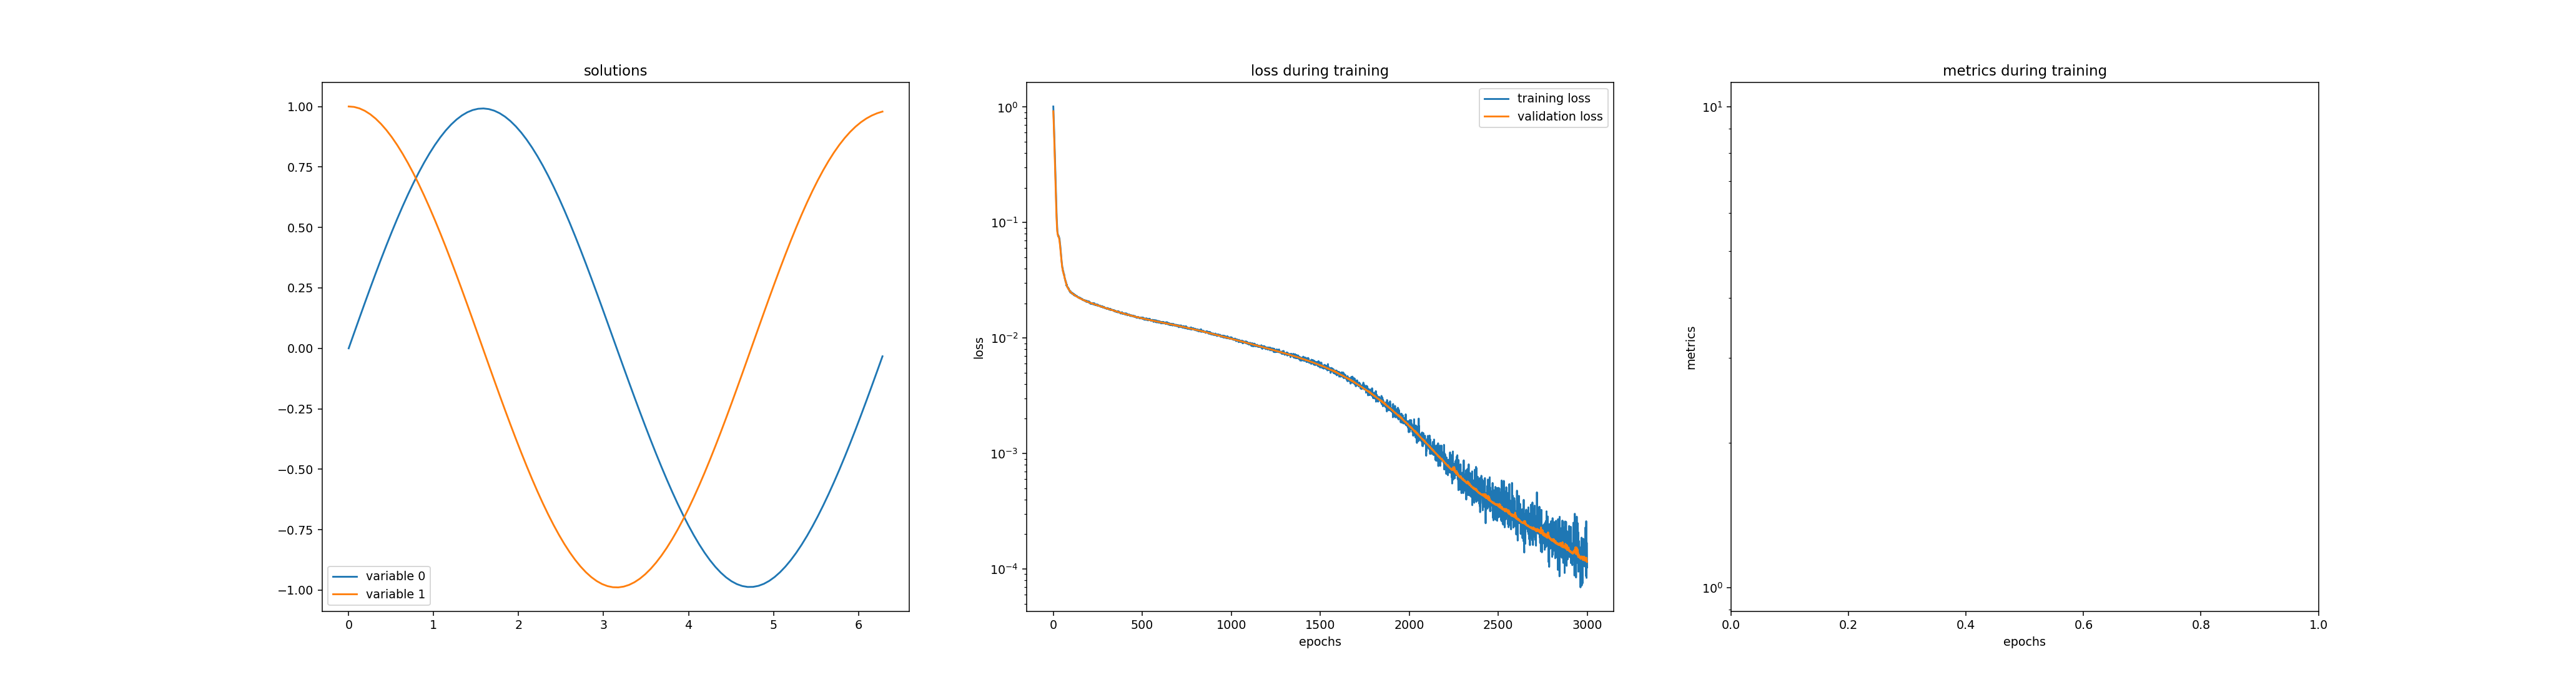

C:\Users\Aphelios\Desktop\FYP\codes\I_AM_MASTER\neurodiffeq\ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(
C:\Users\Aphelios\Desktop\FYP\codes\I_AM_MASTER\neurodiffeq\solvers.py:459: UserWarning: Passing `monitor` is deprecated, use a MonitorCallback and pass a list of callbacks instead
  warnings.warn("Passing `monitor` is deprecated, "


In [16]:
# specify the ODE system
parametric_circle = lambda u1, u2, t : [diff(u1, t) - u2, 
                                        diff(u2, t) + u1]
# specify the initial conditions
init_vals_pc = [
    IVP(t_0=0.0, u_0=0.0),
    IVP(t_0=0.0, u_0=1.0)
]

# solve the ODE system
solution_pc, _ = solve_system(
    ode_system=parametric_circle, conditions=init_vals_pc, t_min=0.0, t_max=2*np.pi, 
    max_epochs=3000,
    monitor=Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100)
)

`solve_system` returns a tuple, where the first entry is the solution as a function and the second entry is the loss history as a list. The solution is a function that maps $t$ to $[u_0, u_1, ..., u_{m-1}]$. It accepts `numpy.array` or `torch.Tensor` as its input. 

Here we compare the ANN-based solution with the analytical solution:

<IPython.core.display.Javascript object>


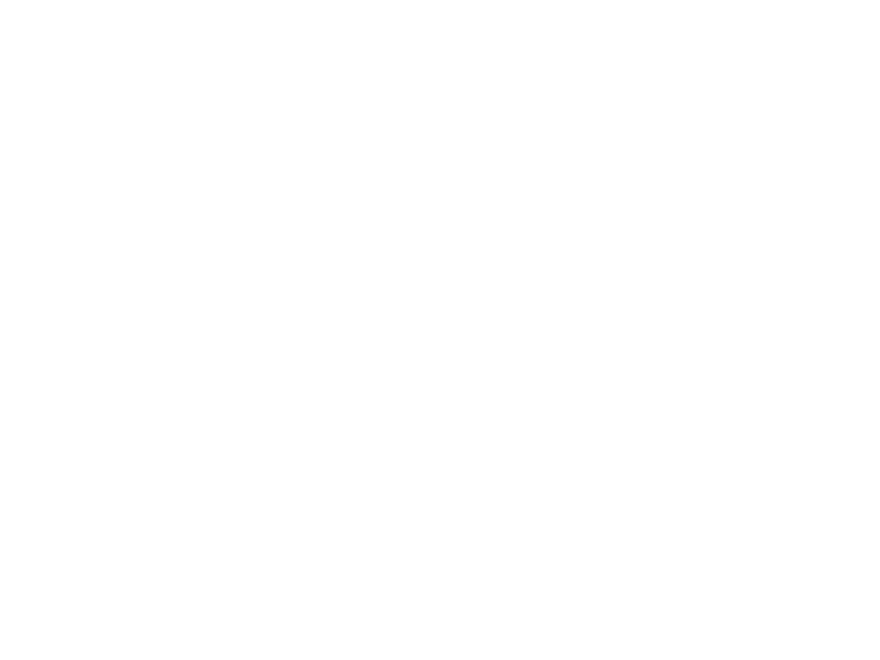

In [17]:
ts = np.linspace(0, 2*np.pi, 100)
u1_net, u2_net = solution_pc(ts, to_numpy=True)
u1_ana, u2_ana = np.sin(ts), np.cos(ts)

plt.figure()
plt.plot(ts, u1_net, label='ANN-based solution of $u_1$')
plt.plot(ts, u1_ana, '.', label='Analytical solution of $u_1$')
plt.plot(ts, u2_net, label='ANN-based solution of $u_2$')
plt.plot(ts, u2_ana, '.', label='Analytical solution of $u_2$')
plt.ylabel('u')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

### Systems of ODE Example 2: Lotka–Volterra equations

The previous examples are rather simple because they are both linear ODE systems. We have numerous existing numerical methods that solve these linear ODEs very well. To show the capability neurodiffeq, let's see this example of *nonlinear* ODEs.

Lotka–Volterra equations are a pair of nonlinear ODE frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey:

$$\begin{align}
\frac{du}{dt} = \alpha u - \beta uv \\
\frac{dv}{dt} = \delta uv - \gamma v
\end{align}$$

Let $\alpha = \beta = \delta = \gamma = 1$. Here we solve this pair of ODE when $u(0) = 1.5$ and $v(0) = 1.0$.

If not specified otherwise, `solve` and `solve_system` will use a fully-connected network with 1 hidden layer with 32 hidden units (tanh activation) to approximate each dependent variables. In some situations, we may want to use our own neural network. For example, the default neural net is not good at solving a problem where the solution oscillates. However, if we know in advance that the solution oscillates, we can use sin as activation function, which resulted in much faster convergence.

`neurodiffeq.FCNN` is a fully connected neural network. It is initiated by the following parameters:

* `hidden_units`: number of units in each hidden layer. If you have 3 hidden layers with 32, 64, and 16 neurons respectively, `hidden_units` should be a tuple `(32, 64, 16)`.

* `actv`: a `torch.nn.Module` *class*. e.g. `nn.Tanh`, `nn.Sigmoid`.

Here we will use another keyword for `solve_system`:

* `nets`: a list of networks to be used to approximate each dependent variable

In [18]:
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation

<IPython.core.display.Javascript object>


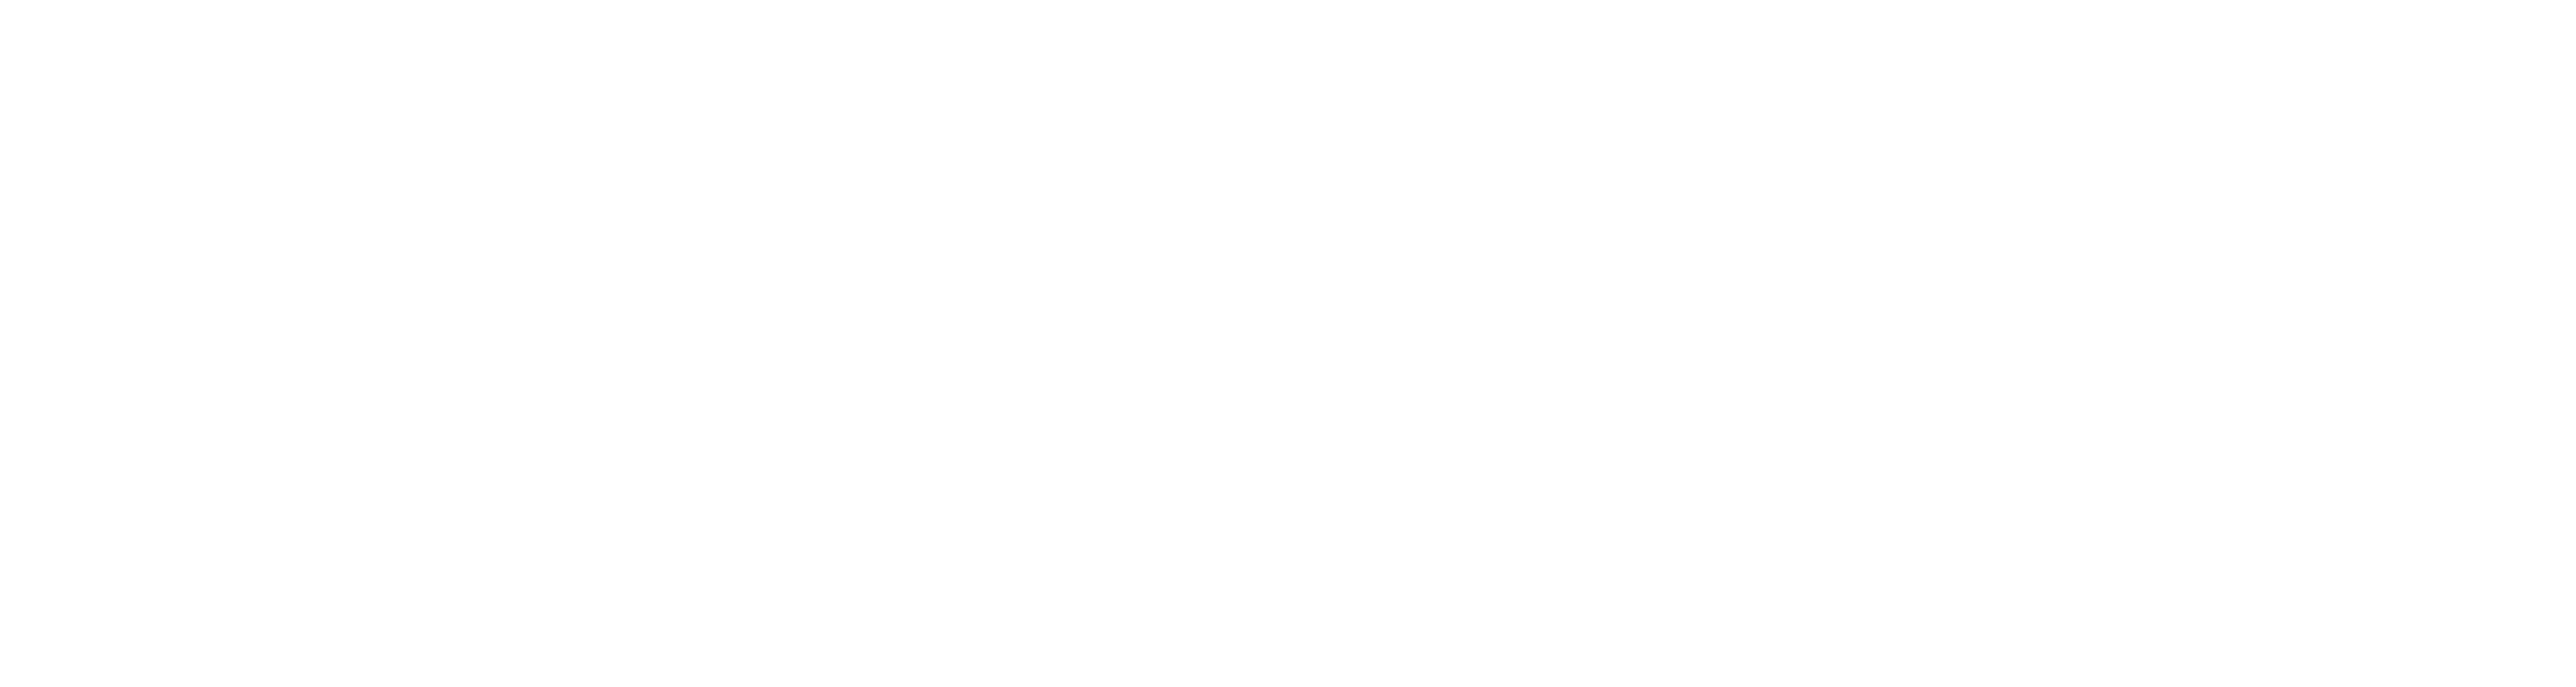

C:\Users\Aphelios\Desktop\FYP\codes\I_AM_MASTER\neurodiffeq\ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(
C:\Users\Aphelios\Desktop\FYP\codes\I_AM_MASTER\neurodiffeq\solvers.py:459: UserWarning: Passing `monitor` is deprecated, use a MonitorCallback and pass a list of callbacks instead
  warnings.warn("Passing `monitor` is deprecated, "


In [19]:
# specify the ODE system and its parameters
alpha, beta, delta, gamma = 1, 1, 1, 1
lotka_volterra = lambda u, v, t : [ diff(u, t) - (alpha*u  - beta*u*v), 
                                    diff(v, t) - (delta*u*v - gamma*v), ]
# specify the initial conditions
init_vals_lv = [
    IVP(t_0=0.0, u_0=1.5),  # 1.5 is the value of u at t_0 = 0.0
    IVP(t_0=0.0, u_0=1.0),  # 1.0 is the value of v at t_0 = 0.0
]

# specify the network to be used to approximate each dependent variable
# the input units and output units default to 1 for FCNN
nets_lv = [
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=SinActv),
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=SinActv)
]

# solve the ODE system
solution_lv, _ = solve_system(
    ode_system=lotka_volterra, conditions=init_vals_lv, t_min=0.0, t_max=12, 
    nets=nets_lv, max_epochs=3000,
    monitor=Monitor1D(t_min=0.0, t_max=12, check_every=100)
)

### Tired of the annoying warning messages? Let's get rid of them by using a 'Solver'

Now that you are familiar with the usage of `solve`, let's try the second way of solving ODEs -- using a `neurodiffeq.solvers.Solver1D` instance. If you are familiar with `sklearn`, the workflow with a *Solver* is quite similar.

1. Instantiate a solver. (Specify the ODE/PDE system, initial/boundary conditions, problem domain, etc.)
2. Fit the solver (Specify number of epochs to train, callbacks in each epoch, monitor, etc.)
3. Get the solutions and other internal variables.

**This is the recommended way of solving ODEs (and PDEs later). Once you learn to use a Solver, you should stick to this way instead of using a** `solve` **function.**

<IPython.core.display.Javascript object>


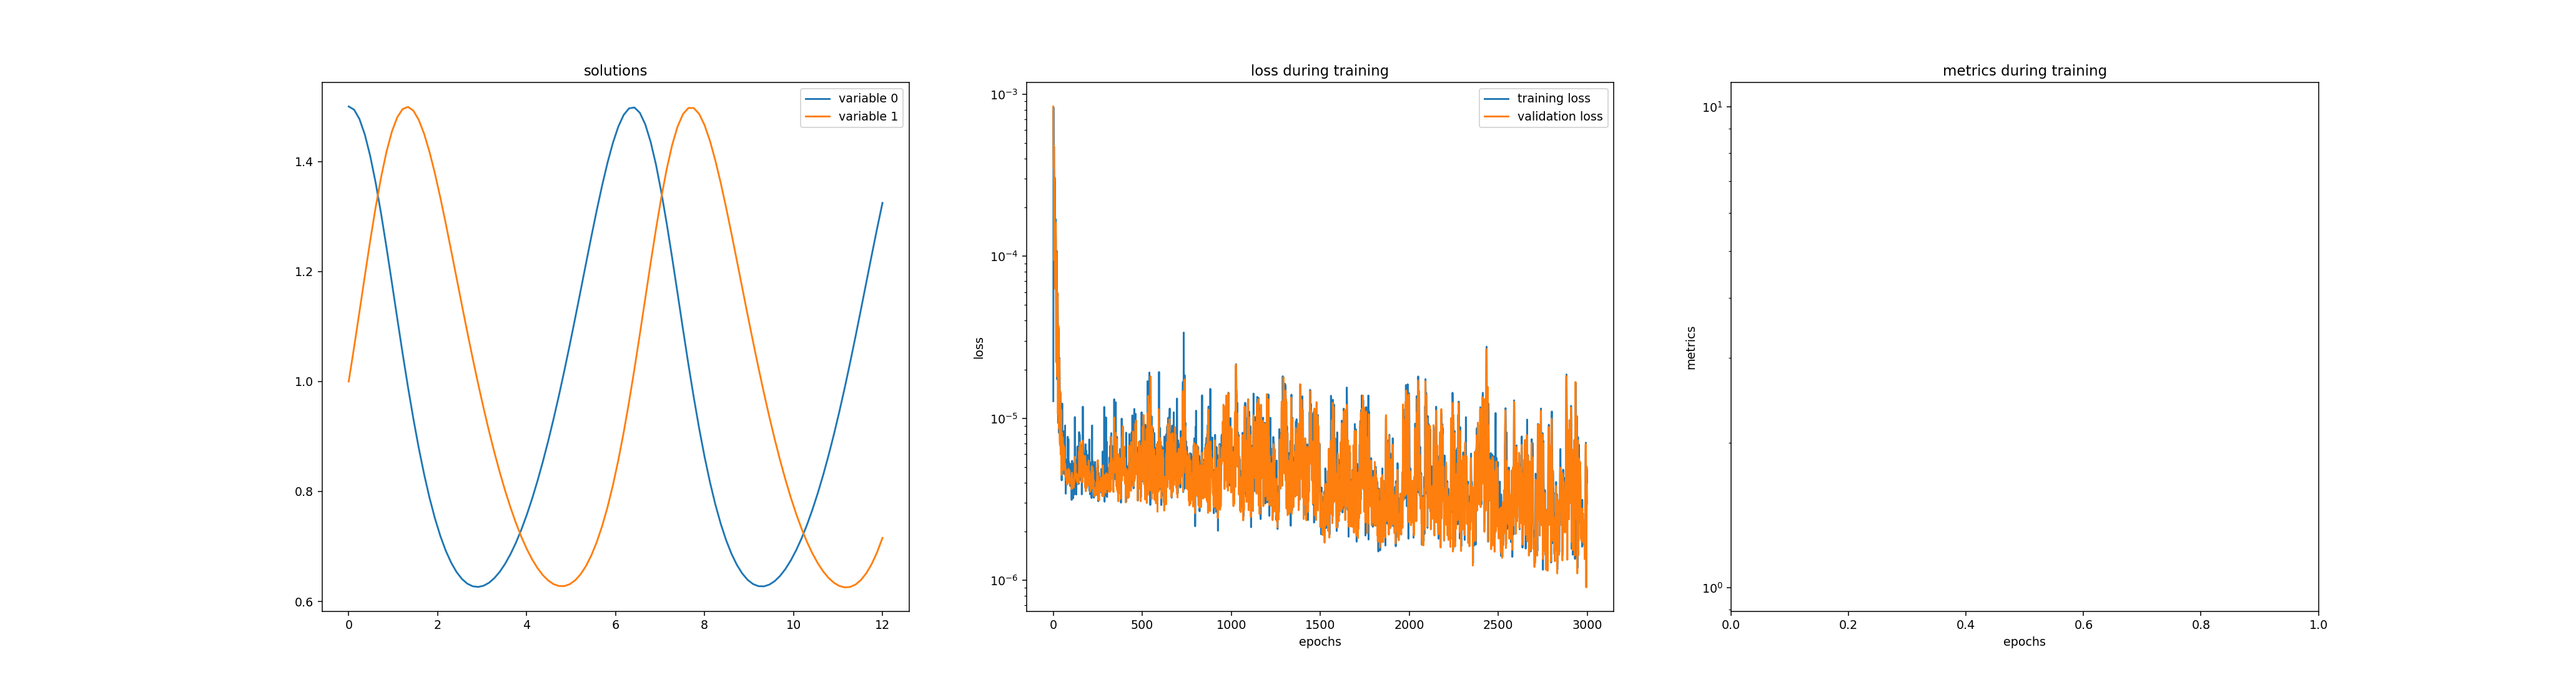

In [26]:
from neurodiffeq.solvers import Solver1D

# Let's create a monitor first
monitor = Monitor1D(t_min=0.0, t_max=12.0, check_every=100)
# ... and turn it into a Callback instance
monitor_callback = monitor.to_callback()

# Instantiate a solver instance
solver = Solver1D(
    ode_system=lotka_volterra,
    conditions=init_vals_lv,
    t_min=0.1,
    t_max=12.0,
    nets=nets_lv,
)

# Fit the solver (i.e., train the neural networks)
solver.fit(max_epochs=3000, callbacks=[monitor_callback])

# Get the solution
solution_lv = solver.get_solution()

<IPython.core.display.Javascript object>


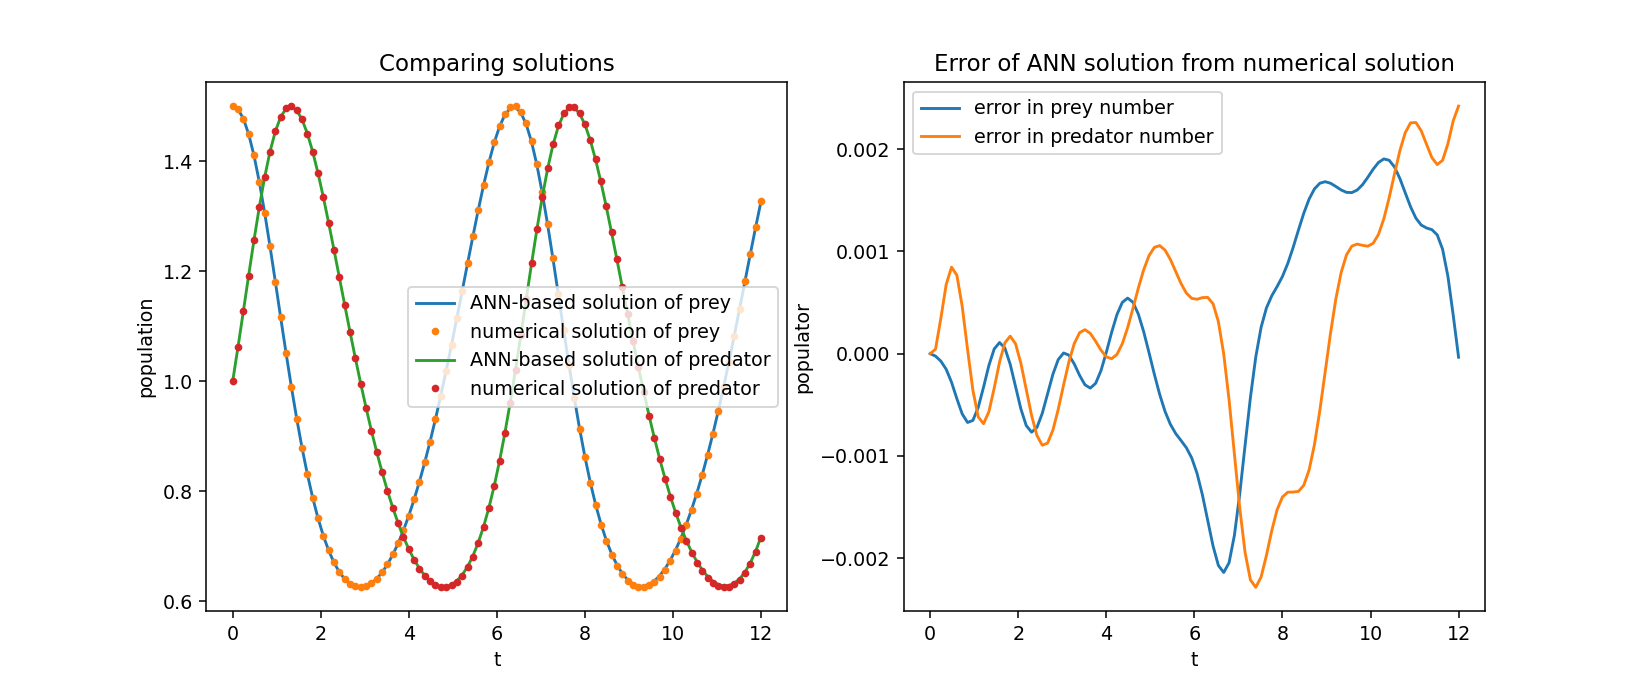

In [27]:
ts = np.linspace(0, 12, 100)

# ANN-based solution
prey_net, pred_net = solution_lv(ts, to_numpy=True)

# numerical solution
from scipy.integrate import odeint
def dPdt(P, t):
    return [P[0]*alpha - beta*P[0]*P[1], delta*P[0]*P[1] - gamma*P[1]]
P0 = [1.5, 1.0]
Ps = odeint(dPdt, P0, ts)
prey_num = Ps[:,0]
pred_num = Ps[:,1]

fig = plt.figure(figsize=(12, 5))
ax1, ax2 = fig.subplots(1, 2)
ax1.plot(ts, prey_net, label='ANN-based solution of prey')
ax1.plot(ts, prey_num, '.', label='numerical solution of prey')
ax1.plot(ts, pred_net, label='ANN-based solution of predator')
ax1.plot(ts, pred_num, '.', label='numerical solution of predator')
ax1.set_ylabel('population')
ax1.set_xlabel('t')
ax1.set_title('Comparing solutions')
ax1.legend()

ax2.set_title('Error of ANN solution from numerical solution')
ax2.plot(ts, prey_net-prey_num, label='error in prey number')
ax2.plot(ts, pred_net-pred_num, label='error in predator number')
ax2.set_ylabel('populator')
ax2.set_xlabel('t')
ax2.legend()